# FIT5202 Assignment 2A : Building Models for Building Energy Prediction

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Hyperparameter Tuning and Model Optimisation](#part-3)  
Please add code/markdown cells as needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided Docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 32MB, and to run locally with all CPU cores on your machine

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment2A"
# Setup configuration parameters for Spark (16g/8g memory for 32 gb ram) (32 MB partition size)
spark_conf = SparkConf().setMaster(master).setAppName(app_name) \
                        .set("spark.executor.memory", "16g") \
                        .set("spark.driver.memory", "8g") \
                        .set("spark.sql.files.maxPartitionBytes", "33554432") 


# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

from pyspark.sql import functions as F

1.1.2 Write code to define the schemas for the datasets, following the data types suggested in the metadata file. 

In [2]:
# Adapted from GPT
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, DecimalType, TimestampType
)

# 1. Meters Table
meters_schema = StructType([
    StructField("building_id", IntegerType(), False),
    StructField("meter_type", StringType(), False),   # Char(1) -> StringType
    StructField("ts", TimestampType(), False),
    StructField("value", DecimalType(15, 4), False),
    StructField("row_id", IntegerType(), False)
])

# 2. Buildings Table
buildings_schema = StructType([
    StructField("site_id", IntegerType(), False),
    StructField("building_id", IntegerType(), False),
    StructField("primary_use", StringType(), True),
    StructField("square_feet", IntegerType(), True),
    StructField("floor_count", IntegerType(), True),
    StructField("row_id", IntegerType(), False),
    StructField("year_built", IntegerType(), True),
    StructField("latent_y", DecimalType(6, 4), True),
    StructField("latent_s", DecimalType(6, 4), True),
    StructField("latent_r", DecimalType(6, 4), True)
])

# 3. Weather Table
weather_schema = StructType([
    StructField("site_id", IntegerType(), False),
    StructField("timestamp", TimestampType(), False),
    StructField("air_temperature", DecimalType(5, 3), True),
    StructField("cloud_coverage", DecimalType(5, 3), True), # Is an Integer, but ends with a ".0", so read as a DecimalType
    StructField("dew_temperature", DecimalType(5, 3), True),
    StructField("sea_level_pressure", DecimalType(8, 3), True),
    StructField("wind_direction", DecimalType(5, 3), True), # Is an Integer, but ends with a ".0", so read as a DecimalType
    StructField("wind_speed", DecimalType(5, 3), True)
])


1.1.3 Using your schemas, load the CSV files into separate data frames. Print the schemas of all data frames. 

In [3]:
# from GPT
meters_df = spark.read.csv(
    "data/meters.csv",
    header=True,
    schema=meters_schema
)

buildings_df = spark.read.csv(
    "data/building_information.csv",
    header=True,
    schema=buildings_schema
)

weather_df = spark.read.csv(
    "data/weather.csv",
    header=True,
    schema=weather_schema
)
print("Meters DF:")
meters_df.printSchema()
print("Buildings DF:")
buildings_df.printSchema()
print("Weather DF")
weather_df.printSchema()


Meters DF:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- value: decimal(15,4) (nullable = true)
 |-- row_id: integer (nullable = true)

Buildings DF:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(6,4) (nullable = true)
 |-- latent_s: decimal(6,4) (nullable = true)
 |-- latent_r: decimal(6,4) (nullable = true)

Weather DF
root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- air_temperature: decimal(5,3) (nullable = true)
 |-- cloud_coverage: decimal(5,3) (nullable = true)
 |-- dew_temperature: decimal(5,3) (nullable = true)
 |-- sea_level_pressure: decimal(8,3) (nullable = true)
 |-- win

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In this section, we primarily have three tasks:  
1.2.1 The dataset includes sensors with hourly energy measurements. However, as a grid operator, we don’t need this level of granularity and lowering it can reduce the amount of data we need to process. For each building, we will aggregate the metered energy consumption in 6-hour intervals (0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59). This will be our target (label) column for this prediction. Perform the aggregation for each building.


In [4]:
# Adapted from A1 and GPT
# Meters df
# Split timestamp to date and time bucket
meters_df = meters_df.withColumn("date", F.to_date("ts")).withColumn(
    "time",
    F.when(F.hour("ts") <= 5, "0-6h")
     .when(F.hour("ts") <= 11, "6-12h")
     .when(F.hour("ts") <= 17, "12-18h")
     .when(F.hour("ts") <= 23, "18-24h")
     .otherwise("unknown")   # catch any unexpected cases
)

# Aggregate by time bucket
meters_df = (
    meters_df.groupBy("building_id", "meter_type", "date", "time")
    .agg(F.sum("value").cast(DecimalType(15, 4)).alias("power_usage"))
)
meters_df.show(3)


+-----------+----------+----------+------+-----------+
|building_id|meter_type|      date|  time|power_usage|
+-----------+----------+----------+------+-----------+
|        244|         c|2022-01-01| 6-12h|    36.3642|
|       1214|         c|2022-01-01| 6-12h|   444.3222|
|       1259|         c|2022-01-01|12-18h|   385.0202|
+-----------+----------+----------+------+-----------+
only showing top 3 rows



In the weather dataset, there are some missing values (null or empty strings). It may lower the quality of our model. Imputation is a way to deal with those missing values. Imputation is the process of replacing missing values in a dataset with substituted, or "imputed," values. It's a way to handle gaps in your data so that you can still analyse it effectively without having to delete incomplete records.  
1.2.2 Refer to the Spark MLLib imputation API and fill in the missing values in the weather dataset. You can use mean values as the strategy.  https://spark.apache.org/docs/3.5.5/api/python/reference/api/pyspark.ml.feature.Imputer.html

In [5]:
# from GPT
# Weather df
# Split timestamp to date, month, time bucket
weather_df = weather_df.withColumn("date", F.to_date("timestamp")).withColumn(
    "time",
    F.when(F.hour("timestamp") <= 5, "0-6h")
     .when(F.hour("timestamp") <= 11, "6-12h")
     .when(F.hour("timestamp") <= 17, "12-18h")
     .when(F.hour("timestamp") <= 23, "18-24h")
).withColumn("month", F.month("timestamp"))

# Choose which columns to impute
impute_cols = [
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "sea_level_pressure",
    "wind_direction",
    "wind_speed"
]

# Global means once
global_means = weather_df.select(
    *[F.mean(c).alias(c) for c in impute_cols]
).first().asDict()

# Step 1: site_id + month
site_month_means = weather_df.groupBy("site_id", "month").agg(
    *[F.mean(c).alias(f"{c}_site_month_mean") for c in impute_cols]
)
weather_df = weather_df.join(site_month_means, on=["site_id", "month"], how="left")
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.col(f"{c}_site_month_mean"))
    ).drop(f"{c}_site_month_mean")

# Garbage collection
weather_df = weather_df.unpersist()

# Step 2: site_id
site_means = weather_df.groupBy("site_id").agg(
    *[F.mean(c).alias(f"{c}_site_mean") for c in impute_cols]
)
weather_df = weather_df.join(site_means, on="site_id", how="left")
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.col(f"{c}_site_mean"))
    ).drop(f"{c}_site_mean")

# Step 3: global fallback
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.lit(global_means[c]))
    )
    
# Garbage collection
del site_month_means
del site_means
del global_means
spark.catalog.clearCache()
    
# Aggregate by time bucket
weather_df = (
    weather_df.groupBy("site_id", "date", "time", "month")
    .agg(
        F.mean("air_temperature").cast(DecimalType(5, 3)).alias("air_temperature"),
        F.mean("cloud_coverage").cast(DecimalType(5, 3)).alias("cloud_coverage"),
        F.mean("dew_temperature").cast(DecimalType(5, 3)).alias("dew_temperature"),
        F.mean("sea_level_pressure").cast(DecimalType(8, 3)).alias("sea_level_pressure"),
        F.mean("wind_direction").cast(DecimalType(5, 3)).alias("wind_direction"),
        F.mean("wind_speed").cast(DecimalType(5, 3)).alias("wind_speed"),        
    )
)

weather_df.show(3)


+-------+----------+------+-----+---------------+--------------+---------------+------------------+--------------+----------+
|site_id|      date|  time|month|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|
+-------+----------+------+-----+---------------+--------------+---------------+------------------+--------------+----------+
|      1|2022-01-01|  0-6h|    1|          2.800|         0.000|          1.950|          1022.067|        49.722|     1.617|
|      1|2022-01-01| 6-12h|    1|          3.117|         0.000|          1.683|          1021.850|        73.222|     2.300|
|      1|2022-01-01|12-18h|    1|          7.450|         0.000|          5.450|          1015.683|        59.667|     5.917|
+-------+----------+------+-----+---------------+--------------+---------------+------------------+--------------+----------+
only showing top 3 rows



We know that different seasons may affect energy consumption—for instance, a heater in winter and a cooler in summer. Extracting peak seasons (summer and winter) or off-peak seasons (Spring and Autumn) might be more useful than directly using the month as numerical values.   
1.2.3 The dataset has 16 sites in total, whose locations may span across different countries. Add a column (peak/off-peak) to the weather data frame based on the average air temperature. The top 3 hottest months and the 3 coldest months are considered “peak”, and the rest of the year is considered “off-peak”. 

In [6]:
from pyspark.sql.window import Window
# adapted from A1, tuned with GPT
# Group median temp per site/month
monthly_temp = (
    weather_df
    .groupBy("site_id", "month")
    .agg(F.expr("percentile_approx(air_temperature, 0.5)").alias("median_temp"))
)

# Define windows
w_asc = Window.partitionBy("site_id").orderBy(F.col("median_temp").asc())
w_desc = Window.partitionBy("site_id").orderBy(F.col("median_temp").desc())

# Rank + add peak/offpeak column in one step, drop ranks immediately
monthly_temp_ranked = (
    monthly_temp
    .withColumn("rank_cold", F.row_number().over(w_asc))
    .withColumn("rank_hot", F.row_number().over(w_desc))
    .withColumn(
        "peak_offpeak",
        F.when((F.col("rank_cold") <= 3) | (F.col("rank_hot") <= 3), "peak")
         .otherwise("off-peak")
    )
    .select("site_id", "month", "median_temp", "peak_offpeak")    
)

# Join back
weather_df = weather_df.join(monthly_temp_ranked, ["site_id","month"], "left")

weather_df.show(3)

# Delete temporary variable to save memory
del monthly_temp_ranked

+-------+-----+----------+------+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|site_id|month|      date|  time|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|median_temp|peak_offpeak|
+-------+-----+----------+------+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|      1|    1|2022-01-01|  0-6h|          2.800|         0.000|          1.950|          1022.067|        49.722|     1.617|      6.417|        peak|
|      1|    1|2022-01-01| 6-12h|          3.117|         0.000|          1.683|          1021.850|        73.222|     2.300|      6.417|        peak|
|      1|    1|2022-01-01|12-18h|          7.450|         0.000|          5.450|          1015.683|        59.667|     5.917|      6.417|        peak|
+-------+-----+----------+------+---------------+--------------+---------------+--------------

Create a data frame with all relevant columns at this stage, we refer to this data frame as feature_df.

In [7]:
# Meters -> Join with Buildings (building_id)
meters_buildings = meters_df.join(buildings_df, ["building_id"], "left")
# Meters + Buildings -> Join with Weather (site_id, date, time)
feature_df = meters_buildings.join(weather_df, ["site_id", "date", "time"])

# Print schema for ease of info
# Extra columns added: month, median_temp, peak_offpeak
print("Feature df schema: ")
feature_df.printSchema()

Feature df schema: 
root
 |-- site_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = false)
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- power_usage: decimal(15,4) (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(6,4) (nullable = true)
 |-- latent_s: decimal(6,4) (nullable = true)
 |-- latent_r: decimal(6,4) (nullable = true)
 |-- month: integer (nullable = true)
 |-- air_temperature: decimal(5,3) (nullable = true)
 |-- cloud_coverage: decimal(5,3) (nullable = true)
 |-- dew_temperature: decimal(5,3) (nullable = true)
 |-- sea_level_pressure: decimal(8,3) (nullable = true)
 |-- wind_direction: decimal(5,3) (nullable = true)
 |-- wind_speed: decimal(5,3) (nullable = true)
 |-- median_temp: decimal

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
You can use either the CDA or the EDA method mentioned in Lab 5.  
Some ideas for CDA:  
a)	Older building may not be as efficient as new ones, therefore need more energy for cooling/heating. It’s not necessarily true though, if the buildings are built with higher standard or renovated later.  
b)	A multifloored or larger building obviously consumes more energy.  

1.	With the feature_df, write code to show the basic statistics:  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile;  
b) For each non-numeric column, display the top-5 values and the corresponding counts;  
c) For each boolean column, display the value and count. (note: pandas describe is allowed for this task.) (5%)

In [8]:
# Get columns grouped by type
numeric_cols = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith(("int", "double", "float", "decimal", "long", "short"))]
string_cols  = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith("string")]
boolean_cols = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith("boolean")]

# === A) Numeric columns stats ===
for col in numeric_cols:
    # Base aggregations
    stats = feature_df.select(
        F.count(F.col(col)).alias("count"),
        F.mean(F.col(col)).cast(DecimalType(15, 4)).alias("mean"),
        F.stddev(F.col(col)).cast(DecimalType(15, 4)).alias("stddev"),
        F.min(F.col(col)).alias("min"),
        F.max(F.col(col)).cast(DecimalType(15, 4)).alias("max"),
    ).collect()[0].asDict()

    # Add quantiles
    quantiles = feature_df.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    stats.update({"25%": quantiles[0], "50%": quantiles[1], "75%": quantiles[2]})

    # Convert to DataFrame for nice display
    df_stats = feature_df.sparkSession.createDataFrame([stats])
    print(f"--- Stats for numeric column: {col} ---")
    df_stats.show(truncate=False)

# === B) Non-numeric (string) columns top-5 values ===
for col in string_cols:
    print(f"--- Top 5 values for string column: {col} ---")
    feature_df.groupBy(col).count().orderBy(F.desc("count")).show(5)

# === C) Boolean columns counts ===
for col in boolean_cols:
    print(f"--- Value counts for boolean column: {col} ---")
    feature_df.groupBy(col).count().show()



--- Stats for numeric column: site_id ---
+---+---+----+-------+---------------------+--------------------+---+--------------------+
|25%|50%|75% |count  |max                  |mean                |min|stddev              |
+---+---+----+-------+---------------------+--------------------+---+--------------------+
|3.0|9.0|13.0|2300550|15.000000000000000000|7.857800000000000000|0  |5.142600000000000000|
+---+---+----+-------+---------------------+--------------------+---+--------------------+

--- Stats for numeric column: building_id ---
+-----+-----+------+-------+-----------------------+----------------------+---+----------------------+
|25%  |50%  |75%   |count  |max                    |mean                  |min|stddev                |
+-----+-----+------+-------+-----------------------+----------------------+---+----------------------+
|350.0|857.0|1180.0|2300550|1448.000000000000000000|786.878600000000000000|0  |433.343000000000000000|
+-----+-----+------+-------+----------------

--- Stats for numeric column: sea_level_pressure ---
+--------+--------+--------+-------+-----------------------+-----------------------+----------------------+--------------------+
|25%     |50%     |75%     |count  |max                    |mean                   |min                   |stddev              |
+--------+--------+--------+-------+-----------------------+-----------------------+----------------------+--------------------+
|1011.835|1016.158|1020.117|2300550|1045.283000000000000000|1016.069700000000000000|970.617000000000000000|6.770600000000000000|
+--------+--------+--------+-------+-----------------------+-----------------------+----------------------+--------------------+

--- Stats for numeric column: wind_direction ---
+------+------+------+-------+---------------------+---------------------+--------------------+---------------------+
|25%   |50%   |75%   |count  |max                  |mean                 |min                 |stddev               |
+------+------+-

2.	Explore the dataframe and write code to present two plots of multivariate analysis, describe your plots and discuss the findings from the plots. (5% each).  
○	150 words max for each plot’s description and discussion.  
○	Note: In the building metadata table, there are some latent columns (data that may or may not be helpful, their meanings is unknown due to privacy and data security concerns).  
○	Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc. You can refer to https://samplecode.link  


In [9]:
# Modular pipeline for multivariate analysis. Adapted from GPT from A1
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, StringIndexerModel
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1) Feature configs (all definitions live here)
# ------------------------------------------------------------

FEATURE_GROUPS = {
    "building": {
        "numeric": ["square_feet", "floor_count", "year_built", "latent_y", "latent_s", "latent_r"],
        "categorical": {"primary_use": "primary_use_ohe"},
        "custom_numeric": {
        }
    },
    "weather": {
        "numeric": ["cloud_coverage", "sea_level_pressure", "wind_direction", "wind_speed"],
        "categorical": {"site_id": "site_id_ohe", "time": "time_ohe"},
        "custom_numeric": {
            "dew_depression": F.col("air_temperature") - F.col("dew_temperature"),
            "nonideal_temp": (F.col("air_temperature") - 18)**2
            
        }
    }
}

# ------------------------------------------------------------
# 2) Data prep: cast + apply custom transformations
# ------------------------------------------------------------
def prepare_dataframe(feature_df, feature_groups):
    # Collect all required columns
    numeric_cols = []
    categorical_cols = []
    custom_exprs = {}
    for grp in feature_groups.values():
        numeric_cols.extend(grp.get("numeric", []))
        categorical_cols.extend(grp.get("categorical", {}).keys())
        custom_exprs.update(grp.get("custom_numeric", {}))
    
    # Start with target
    df = feature_df.withColumn("power_usage", F.col("power_usage").cast(DoubleType()))
    
    # Cast numerics
    for col in numeric_cols:
        df = df.withColumn(col, F.col(col).cast(DoubleType()))
    
    # Apply custom numerics
    for new_col, expr in custom_exprs.items():
        df = df.withColumn(new_col, expr.cast(DoubleType()))
    
    # Final set of columns
    selected_cols = (
        ["power_usage"] + numeric_cols + categorical_cols + list(custom_exprs.keys())
    )
    df = df.select(*selected_cols).dropna()
    
    # Log-transform target
    df = df.withColumn("log_power_usage", F.log1p(F.col("power_usage")))
    
    return df.cache()

df = prepare_dataframe(feature_df, FEATURE_GROUPS)

# ------------------------------------------------------------
# 3) Helper: IQR filter (for log_power_usage only)
# ------------------------------------------------------------
def iqr_filter(df, colname):
    q1, q3 = df.approxQuantile(colname, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df.filter((F.col(colname) >= lower) & (F.col(colname) <= upper))

df = df.sample(False, 0.1, 2025) # 10% sample was initially used to save time. 20% sampling used in final run
df = iqr_filter(df, "log_power_usage").cache()

# ------------------------------------------------------------
# 4) Pipeline building
# ------------------------------------------------------------
def build_feature_stages(group_config):
    stages = []
    input_features = []

    # Categorical → index + encode
    for col, ohe_col in group_config.get("categorical", {}).items():
        idx_col = f"{col}_index"
        indexer = StringIndexer(inputCol=col, outputCol=idx_col, handleInvalid="skip")
        encoder = OneHotEncoder(inputCols=[idx_col], outputCols=[ohe_col])
        stages += [indexer, encoder]
        input_features.append(ohe_col)

    # Numeric (raw + custom)
    input_features += group_config.get("numeric", [])
    input_features += list(group_config.get("custom_numeric", {}).keys())

    # Assembler + scaler
    assembler = VectorAssembler(inputCols=input_features, outputCol="raw_features", handleInvalid="skip")
    scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)
    stages += [assembler, scaler]

    return stages

def make_pipeline(group_config):
    stages = build_feature_stages(group_config)
    lr = LinearRegression(featuresCol="features", labelCol="log_power_usage", maxIter=20)
    return Pipeline(stages=stages + [lr])

pipeline_building = make_pipeline(FEATURE_GROUPS["building"])
pipeline_weather = make_pipeline(FEATURE_GROUPS["weather"])

# ------------------------------------------------------------
# 5) Train/test split + fit
# ------------------------------------------------------------
train, test = df.randomSplit([0.7, 0.3], seed=2025)

building_model = pipeline_building.fit(train)
weather_model = pipeline_weather.fit(train)

building_lr_model = building_model.stages[-1]
weather_lr_model = weather_model.stages[-1]

# ------------------------------------------------------------
# 6) Coefficient extraction
# ------------------------------------------------------------
def extract_coefs_modular(pipeline_model, lr_model, config):
    feature_names = []

    # Numeric + custom numeric
    feature_names += config.get("numeric", [])
    feature_names += list(config.get("custom_numeric", {}).keys())

    # Expand categorical OHE features
    for col in config.get("categorical", {}):
        idx_stage = next(s for s in pipeline_model.stages if isinstance(s, StringIndexerModel) and s.getInputCol() == col)
        labels = idx_stage.labels
        feature_names += [f"{col}:{lbl}" for lbl in labels[1:]]  # drop baseline

    coefs = lr_model.coefficients.toArray()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    return coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)

building_coef_df = extract_coefs_modular(building_model, building_lr_model, FEATURE_GROUPS["building"])
weather_coef_df = extract_coefs_modular(weather_model, weather_lr_model, FEATURE_GROUPS["weather"])

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
evaluator_r2 = RegressionEvaluator(labelCol="log_power_usage", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="log_power_usage", predictionCol="prediction", metricName="rmse")

r2_building = evaluator_r2.evaluate(building_model.transform(test).cache())
rmse_building = evaluator_rmse.evaluate(building_model.transform(test).cache())

r2_weather = evaluator_r2.evaluate(weather_model.transform(test).cache())
rmse_weather = evaluator_rmse.evaluate(weather_model.transform(test).cache())

print("\n=== Building model evaluation ===")
print(f"R²   : {r2_building:.4f}")
print(f"RMSE : {rmse_building:.4f}")

print("\n=== Weather model evaluation ===")
print(f"R²   : {r2_weather:.4f}")
print(f"RMSE : {rmse_weather:.4f}")

# ------------------------------------------------------------
# 8) Plotting
# ------------------------------------------------------------
def plot_coefs(coef_df, title, threshold=0.1):
    coef_df = coef_df.copy()
    coef_df["color"] = coef_df["coef"].apply(
        lambda x: "steelblue" if abs(x) >= threshold else "tomato"
    )
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=coef_df, x="coef", y="feature",
        hue="color", dodge=False,
        palette={"tomato": "tomato", "steelblue": "steelblue"}
    )
    plt.axvline(0, color="black", linestyle="--")
    plt.title(f"{title}\n(Coef Threshold: {threshold})")
    plt.tight_layout()
    plt.show()



=== Building model evaluation ===
R²   : 0.4035
RMSE : 1.3665

=== Weather model evaluation ===
R²   : 0.1988
RMSE : 1.5837


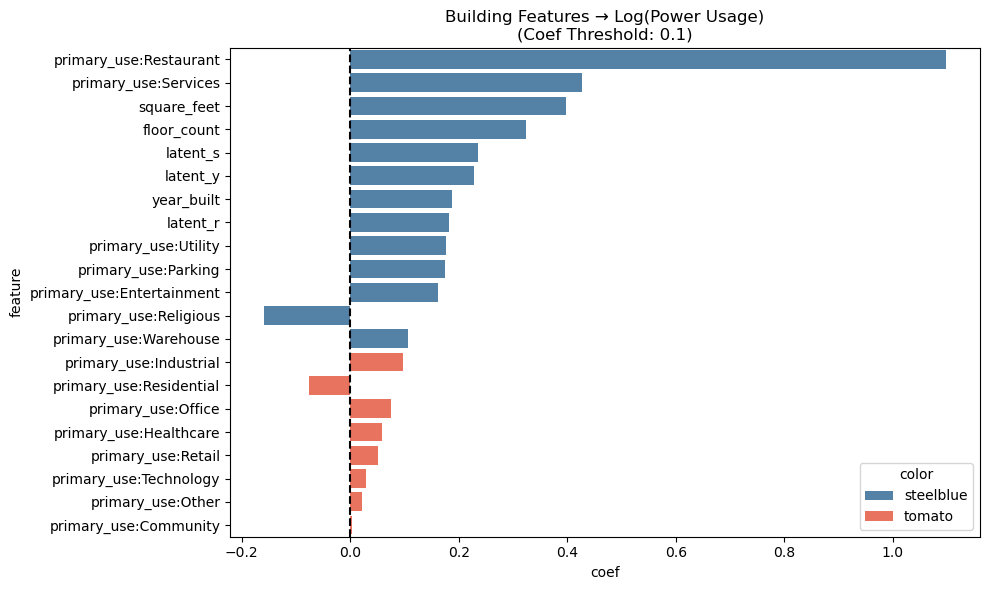

In [10]:
plot_coefs(building_coef_df, "Building Features → Log(Power Usage)")


The multivariate analysis of building features vs log-transformed power usage shows that the power usage varies quite drastically depending on the primary usage of the building, with restaurants using eclipsing the energy usage of every other building type and services being a distant runner up, and religious and residential buildings using notably less energy than every other building type.    

The size of the building is also a obvious predictor of the power usage. All of the features were found to be useful. The R^2 value of building features alone was 0.4035, suggesting that these are only at most half of the story.   


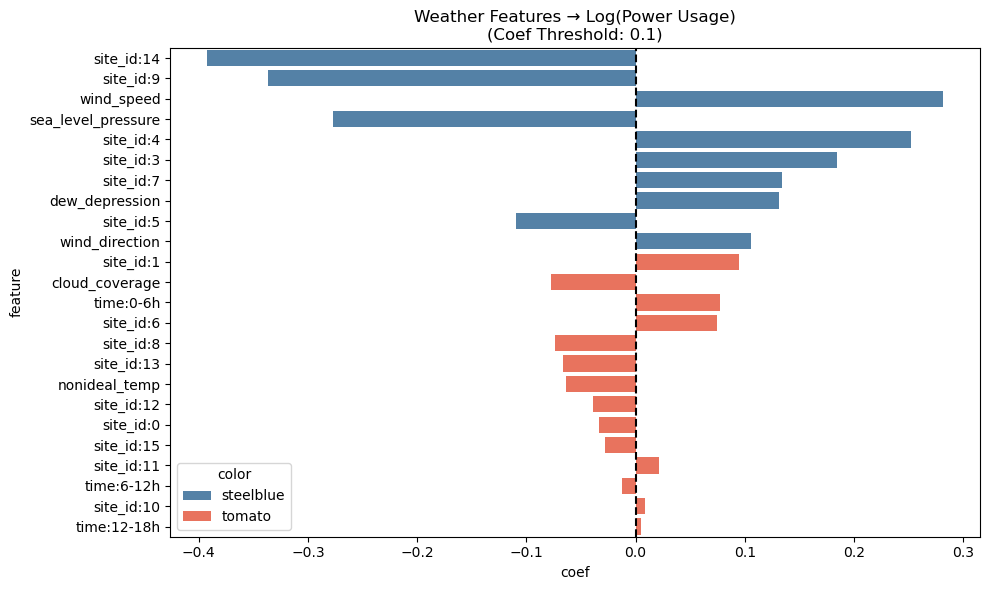

In [11]:
plot_coefs(weather_coef_df, "Weather Features → Log(Power Usage)")


The multivariate analysis of building features vs log-transformed power usage shows that the power usage varies quite drastically depending on the site_id of the building, which indicates that the region of the area is a good predictor.  

Wind speed is a significant predictor of more energy usage, while sea level pressure is a significant predictor of less energy usage. Dew depression and wind direction are also fairly reasonable predictors of energy usage. Surprisingly, the time bucket was a very poor predictor of power usage.  

Yet, these results are difficult to conclude definitively due to the presence of the confounding variable peak-offpeak vastly impacting results, which, combined with the low R^2 value of 0.1948, brings into question the validity of the results. There may likely be more non-linear transformations that may improve predictive quality.  



## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, should not be used to process the data; however, it’s fine to use them to display the result or evaluate your model.  
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you plan to create/transform them.  
○	300 words max for the discussion  
○	Please only use the provided data for model building  
○	You can create/add additional features based on the dataset  
○	Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns  

**Importance of features:**  

month, median_temp, peak_offpeak, which were added as temporary columns earlier, were dropped as they are already represented in the data via the rest of the data, or in the case of median_temp, replaced by air_temperature (which is then replaced by nonideal_temp).  

meter_type as a variable was dropped as it does not represent anything useful to us, and is likely a confounding variable for something else. The latent columns were kept on the assumption that whoever this report would get to would be able to use them.  

peak-offpeak was dropped as it is a confounding variable better represented by nonideal_temp. air_temperature was replaced with nonideal_temp, the squared distance away from 18 degrees (What Is the Ideal Home Temperature - British Gas, n.d.), as intuitively, temperature matters exponentially more with distance from ideal temperature in both directions, and experimentally, a squared difference works better than an exponential magnitude curve. dew_temperature was replaced with dew_depression, the difference of dew temperature and air temperature to be a measure of humidity, a more relevant metric.   


It remains difficult to identify which weather features are important, as the removal of peak-offpeak almost inverted the feature rankings, so I am including all the weather features to be sure.  


2.1.2 Write code to create/transform the columns based on your discussion above.

In [12]:
# Time as a feature was dropped. All other features removed and transformed are identical to 1.3 
# as they were already included there.
FEATURE_GROUPS = {
    "building": {
        "numeric": ["square_feet", "floor_count", "year_built", "latent_y", "latent_s", "latent_r"],
        "categorical": {"primary_use": "primary_use_ohe"},
        "custom_numeric": {
        }
    },
    "weather": {
        "numeric": ["cloud_coverage", "sea_level_pressure", "wind_direction", "wind_speed"],
        "categorical": {"site_id": "site_id_ohe"},
        "custom_numeric": {
            "dew_depression": F.col("air_temperature") - F.col("dew_temperature"),
            "nonideal_temp": (F.col("air_temperature") - 18)**2
            
        }
    }
}

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [13]:
# From GPT
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import SQLTransformer

def build_ml_pipeline(
    categorical_cols,
    numeric_cols,
    label_col="log_power_usage",
    model_type="rf"
):
    """
    Build a Spark ML pipeline for Random Forest or Gradient-Boosted Trees.

    Parameters
    ----------
    categorical_cols : list of str
        List of categorical feature column names.
    numeric_cols : list of str
        List of numeric feature column names.
    label_col : str
        Target column.
    model_type : str
        'rf' for RandomForest, 'gbt' for Gradient-Boosted Tree.

    Returns
    -------
    pipeline : pyspark.ml.Pipeline
        Configured pipeline ready to fit().
    """

    stages = []

    # --- Handle categorical features ---
    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
        for col in categorical_cols
    ]

    encoders = [
        OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
        for col in categorical_cols
    ]

    stages += indexers + encoders

    # --- Numeric features ---
    # Convert decimals to double if necessary
    casted_numeric = [
        F.col(col).cast("double").alias(col) for col in numeric_cols + [label_col]
    ]

    # Vector Assembler
    feature_cols = [f"{c}_ohe" for c in categorical_cols] + numeric_cols
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    stages.append(assembler)

    # (Optional) Feature scaling (trees don’t need it, but handy if you swap in other models)
    # scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    # stages.append(scaler)

#     # Drop intermediate stages
#     drop_stage = SQLTransformer(
#         statement="SELECT features, log_power_usage FROM __THIS__"
#     )
#     stages.append(drop_stage)
    
    # --- Model ---
    if model_type == "rf":
        estimator = RandomForestRegressor(
            featuresCol="features", labelCol=label_col, predictionCol="prediction"
        )
    elif model_type == "gbt":
        estimator = GBTRegressor(
            featuresCol="features", labelCol=label_col, predictionCol="prediction"
        )
    else:
        raise ValueError("model_type must be 'rf' or 'gbt'")

    stages.append(estimator)    


    pipeline = Pipeline(stages=stages)
    return pipeline



**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [14]:
# From GPT
def extract_feature_cols(feature_groups):
    """
    Extract numeric and categorical feature columns from FEATURE_GROUPS.
    Includes both `numeric` and `custom_numeric` for numeric features.

    Parameters
    ----------
    feature_groups : dict
        The FEATURE_GROUPS dictionary.

    Returns
    -------
    numeric_cols : list
    categorical_cols : list
    """

    numeric_cols = []
    categorical_cols = []

    for group, defs in feature_groups.items():
        # numeric
        numeric_cols.extend(defs.get("numeric", []))
        numeric_cols.extend(defs.get("custom_numeric", {}).keys())

        # categorical
        categorical_cols.extend(defs.get("categorical", {}).keys())

    return numeric_cols, categorical_cols

numeric_cols, categorical_cols = extract_feature_cols(FEATURE_GROUPS)
label_col = "log_power_usage" # this has already been IQR filtered from section 1.3

print("Label col:",label_col)
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Random Forest pipeline, default parameters
rf_pipeline = build_ml_pipeline(categorical_cols, numeric_cols, label_col=label_col, model_type="rf")

# GBT pipeline, default parameters
gbt_pipeline = build_ml_pipeline(categorical_cols, numeric_cols, label_col=label_col, model_type="gbt")



Label col: log_power_usage
Numeric cols: ['square_feet', 'floor_count', 'year_built', 'latent_y', 'latent_s', 'latent_r', 'cloud_coverage', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'dew_depression', 'nonideal_temp']
Categorical cols: ['primary_use', 'site_id']


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing, using 2025 as the random seed. You can decide the train/test split ratio based on the resources available on your laptop.  
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset). 

In [15]:
# --- Train/test split ---
train, test = df.randomSplit([0.7, 0.3], seed=2025)


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [16]:
# --- Fit models ---
rf_model = rf_pipeline.fit(train)
gbt_model = gbt_pipeline.fit(train)


2.4.2 For both models (RF and GBT): with the test data, decide on which metrics to use for model evaluation and discuss which one is the better model (no word limit; please keep it concise). You may also use a plot for visualisation (not mandatory).

In [17]:
# from GPT
from pyspark.ml.evaluation import RegressionEvaluator, Evaluator

class RMSLEEvaluator(Evaluator):
    def __init__(self, labelCol="log_power_usage", predictionCol="prediction"):
        super(RMSLEEvaluator, self).__init__()
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        # clip predictions and labels to avoid log(negative)
        df = dataset.withColumn(
            "squared_log_error",
            F.pow(F.log1p(F.col(self.predictionCol)) - F.log1p(F.col(self.labelCol)), 2)
        )
        mean_sle = df.agg(F.mean("squared_log_error")).first()[0]
        return mean_sle ** 0.5

    def isLargerBetter(self):
        # Lower RMSLE is better
        return False


def evaluate_regression_model(model, test_df, label_col="log_power_usage", prediction_col="prediction"):
    """
    Evaluate a regression model on test data with RMSE, MAE, R2, and adjusted R2.
    """
    # Predict
    predictions = model.transform(test_df)

    # Evaluators
    evaluator_rmse = RegressionEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="rmse"
    )
    evaluator_mae = RegressionEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="mae"
    )
    evaluator_r2 = RegressionEvaluator(
        labelCol=label_col, predictionCol=prediction_col, metricName="r2"
    )
    evaluator_rmsle = RMSLEEvaluator(
        labelCol=label_col, predictionCol=prediction_col
    )


    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    rmsle = evaluator_rmsle.evaluate(predictions)

    # Adjusted R2
    n = predictions.count()
    k = len(predictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]) \
        + len(predictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"])
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    return {"rmsle": rmsle, "rmse": rmse, "mae": mae, "r2": r2, "adj_r2": adj_r2}

# --- Evaluate ---
rf_metrics = evaluate_regression_model(rf_model, test, label_col=label_col)
gbt_metrics = evaluate_regression_model(gbt_model, test, label_col=label_col)

print("Random Forest Metrics:", rf_metrics)
print("GBT Metrics:", gbt_metrics)



Random Forest Metrics: {'rmsle': 0.21141035025621444, 'rmse': 1.3015376615858176, 'mae': 0.9649964300982836, 'r2': 0.4588136873505624, 'adj_r2': 0.4584371563381404}
GBT Metrics: {'rmsle': 0.19893823949350325, 'rmse': 1.2199717045483336, 'mae': 0.8931078634475155, 'r2': 0.5245193572002564, 'adj_r2': 0.5241885409847762}


2.4.3 3.	Save the better model (you’ll need it for A2B).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [18]:
# Best model saved below after hyperparameter tuning
    

### Part 3. Hyperparameter Tuning and Model Optimisation <a class="anchor" name="part-3"></a>  
Apply the techniques you have learnt from the labs, for example, CrossValidator, TrainValidationSplit, ParamGridBuilder, etc., to perform further hyperparameter tuning and model optimisation.  
The assessment is based on the quality of your work/process, not the quality of your model. Please include your thoughts/ideas/discussions.

In [19]:
# --- Optimize parameters ---
# --- Evaluator (use RMSLEE as primary metric) ---
evaluator = RMSLEEvaluator(
    labelCol=label_col, 
    predictionCol="prediction"
)

# --- Build Param Grids ---
def build_param_grid(estimator, model_type="rf"):
    """
    Build a ParamGrid for RF or GBT models.
    """
    paramGrid = ParamGridBuilder()
    # Grid search result history are attached in appendix. Approximate ideal parameters found are used:
    ## Round 1 results:
    # minInfoGain 0.01 << 0 slightly worse for RF, much worse for GBT
    # maxDepth 10 >> 5 big improvement
    # numTrees 60 > 40 > 20 very minimal improvement on maxDepth 5, and slightly worse on maxDepth 10, not worth it
    # maxIter 60 > 40 > 20 very minimal improvement, not worth it
    ## Round 2 results:
    # minInfoGain 0.001 slightly helpful for RF, still much worse for GBT
    # maxDepth 15 > 10 a lot better for RF, too much for GBT
    # 20 > 10 numTrees marginal improvement for RF, much better for RF at maxDepth 10 and worse at maxDepth 15
    ## Round 3 results:
    # RF: 
    # numTrees improves very little. set ideal spot at 10 for lighter model
    # maxDepth improves quite a bit. increase more
    # minInfoGain improves very slowly. can be tuned more
    # GBT:
    # maxDepth ideal spot at 10
    # maxIter steadily improves. increase more.
    ## Round 4 results:
    # RF maxDepth ideal spot at 20
    # RF minInfoGain caps at 0.002
    # GBT maxIter hits soft-cap at 40.
    if model_type == "rf":
        paramGrid = (paramGrid
            .addGrid(estimator.numTrees, [10])
            .addGrid(estimator.maxDepth, [20])
            .addGrid(estimator.minInfoGain, [0.002])
        )
    elif model_type == "gbt":
        paramGrid = (paramGrid
            .addGrid(estimator.maxIter, [40])
            .addGrid(estimator.maxDepth, [10])
        )
    else:
        raise ValueError("model_type must be 'rf' or 'gbt'")
    
    return paramGrid.build()

# Grab the last stage (the estimator) for grid building
rf_pipeline = build_ml_pipeline(categorical_cols, numeric_cols, label_col=label_col, model_type="rf")

rf_estimator = rf_pipeline.getStages()[-1]
rf_paramGrid = build_param_grid(rf_estimator, model_type="rf")
rf_cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=3, # more would be better, but this is faster and good enough
    parallelism=1  # don't parallelize, out of memory
)

gbt_estimator = gbt_pipeline.getStages()[-1]
gbt_paramGrid = build_param_grid(gbt_estimator, model_type="gbt")
gbt_cv = CrossValidator(
    estimator=gbt_pipeline,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1
)


# --- Fit cross-validated models ---
train.cache()
rf_cv_model = rf_cv.fit(train)
gbt_cv_model = gbt_cv.fit(train)


In [20]:
# --- Evaluate CV models on test ---
rf_cv_metrics = evaluate_regression_model(rf_cv_model.bestModel, test, label_col)
gbt_cv_metrics = evaluate_regression_model(gbt_cv_model.bestModel, test, label_col)
print("Tuned Random Forest:", rf_cv_metrics)
print("Tuned GBT:", gbt_cv_metrics)

# --- Grid training results ---
def report_cv_results(cv_model, evaluator_name="rmsle"):
    """
    Print out metrics for each parameter combination in a CrossValidator model.
    """
    results = []
    for params, metric in zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics):
        results.append((params, metric))
    
    print(f"Cross-validation results ({evaluator_name}):")
    for i, (params, metric) in enumerate(results):
        param_str = {p.name: v for p, v in params.items()}
        print(f"Combo {i+1}: {param_str} --> {evaluator_name}={metric:.4f}")
    
    return results

# Show all RF parameter combos + RMSE
print("RF parameter grid results:")
rf_results = report_cv_results(rf_cv_model, evaluator_name="rmsle")
print("GBT parameter grid results:")
gbt_results = report_cv_results(gbt_cv_model, evaluator_name="rmsle")


Tuned Random Forest: {'rmsle': 0.16865707832104768, 'rmse': 1.0543618467500837, 'mae': 0.7208974697791796, 'r2': 0.644849288198057, 'adj_r2': 0.6446021916733453}
Tuned GBT: {'rmsle': 0.16904576033125446, 'rmse': 1.0481253427805308, 'mae': 0.7260217997745031, 'r2': 0.6490382643378241, 'adj_r2': 0.6487940822981799}
RF parameter grid results:
Cross-validation results (rmsle):
Combo 1: {'numTrees': 10, 'maxDepth': 20, 'minInfoGain': 0.002} --> rmsle=0.1695
GBT parameter grid results:
Cross-validation results (rmsle):
Combo 1: {'maxIter': 40, 'maxDepth': 10} --> rmsle=0.1716


In [21]:
# Section 2.4.3 3. Save the best model
# Define the path to save the model
model_path = "models/best_model_rmsle"

# Save the better trained model. 
if rf_cv_metrics["rmsle"] < gbt_cv_metrics["rmsle"]:
    rf_cv_model.bestModel.save(model_path)
else:
    gbt_cv_model.bestModel.save(model_path)

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-3"></a>  
How do you utilise datasets with ethics, privacy and security in mind?
1. Define the concepts of data ethics, privacy, and security within the big data domain.  

2. Choose one or more topics to discuss.  
Data Ethics:   
● Analyse how data ethics can influence big data processing;   
● Examine  real-world  examples  of  how  data  ethics  has  been  handled,  both 
positively and negatively.   
● Analyse the balance between technological advancements and ethical 
responsibilities   
Data Privacy:    
● Discuss the challenges and importance of maintaining privacy in big data.   
● Investigate regulations and laws that govern data privacy, such as GDPR.   
● Evaluate tools and techniques used to ensure privacy, and suggest 
improvements or new methodologies.   
Data Security:   
● Explore the potential security risks associated with big data processing.   
● Assess the measures currently in place to secure big data, including encryption, 
authentication, and authorisation.  

3. Write a summary of your findings from (2)  


**Part 4.1**  
Data ethics: Floridi and Taddeo (2016)    
Data ethics is the branch of ethics that studies and evaluates moral problems related to data, algorithms and corresponding practices in order to formulate morally good solutions. With the automation of much of society, pose pressing issues - are the systems we are automating fair, responsible and respectful of human rights, or are we designing a society that oppresses certain groups by nature?  

Data privacy and security: Jain et al. (2016)  
Privacy:   
Data privacy is the privilege of an individual or group to control how their personal information is collected and used, and to decide to who and to where that information goes. One serious user privacy issue is the identification of personal information during transmission over the Internet.  

Security: Jain et al. (2016)   
Data security is the confidentiality, integrity and availability of data. It gives the ability to be confident that user decisions on data authorization are respected. A key requirement is to prevent data compromise from technology or vulnerabilities in the network through various means.  

**Part 4.2**  
Floridi and Taddeo (2016) highlights that data ethics, if not adhered to, can systematically disadvantage certain groups of people. However, adhering to data ethics too tightly can also result in overly rigid guidelines that stifle progress and productivity. Tanweer et al. (2017) shows an example of data ethics being handled. In this scenario, it resulted in a more inclusive app, which was better aligned with what was actually needed by the disabled people they were making it for. It also ensured that they didn't forget certain groups of disabled people, improving the userbase reach their app had. They also collected as little data as they could, relying on public and anonymous datasets where possible. Their emphasis on reflecting on ethics also ensured that they had ample feedback to work with, making sure that their work is done wisely, and leading to a less invasive, more credible and trustable project. However, all of that came at the cost of slowdowns - the paper describes many detours in their workflow to review, approve and get feedback at every step, which undoubtedly meant massive delays in completing their project.  


**Part 4.3**  
To summarize, data ethics influence big data processing to ensure the resulting applications are usable for a wider and more diverse group of users. It also minimizes the risk of data leakage, while improving credibility and trust. However, this comes at the cost of slowing down progress - all of this takes a lot of time to review and approve.



## References:
Please add your references below:

What is the ideal home temperature - British Gas. (n.d.). https://www.britishgas.co.uk/the-source/no-place-like-home/whats-the-ideal-home-temperature.html  

Floridi, L., & Taddeo, M. (2016). What is data ethics? Philosophical Transactions of the Royal Society a Mathematical Physical and Engineering Sciences, 374(2083), 20160360. https://doi.org/10.1098/rsta.2016.0360  
https://royalsocietypublishing.org/doi/10.1098/rsta.2016.0360  
Jain, P., Gyanchandani, M., & Khare, N. (2016). Big data privacy: a technological perspective and review. Journal of Big Data, 3(1). https://doi.org/10.1186/s40537-016-0059-y  
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-016-0059-y#Sec3  

Tanweer, A., Bolten, N., Drouhard, M., Hamilton, J., Caspi, A., Fiore-Gartland, B., & Tan, K. (2017). Mapping for accessibility: A case study of ethics in data science for social good. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1710.06882


Usage of ChatGPT:  
I used chatgpt to implement frameworks that I discover
https://chatgpt.com/share/68d94b8f-2d80-8005-9b33-08834fa1d1ce
https://chatgpt.com/share/68d94bd8-0acc-8005-b937-c9bb2d6853dd
https://chatgpt.com/share/68d94be4-8348-8005-94f2-001cecac451b
https://chatgpt.com/share/68d94bf4-0dcc-8005-8a81-bf1b04ed21b6
https://chatgpt.com/share/68d94c23-3e54-8005-ad44-66f73eb7aab8


## Appendix:

I have logged my parameter grid search process here. These are the results which led me to decide on the optimal set of parameters to use.   

RF parameter grid results:  
Cross-validation results (rmse):  
Combo 1: {'numTrees': 40, 'maxDepth': 5, 'minInfoGain': 0.0} --> rmse=1.2961  
Combo 2: {'numTrees': 40, 'maxDepth': 5, 'minInfoGain': 0.01} --> rmse=1.2968  
Combo 3: {'numTrees': 40, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.1506  
Combo 4: {'numTrees': 40, 'maxDepth': 10, 'minInfoGain': 0.01} --> rmse=1.1592  
Combo 5: {'numTrees': 60, 'maxDepth': 5, 'minInfoGain': 0.0} --> rmse=1.2957  
Combo 6: {'numTrees': 60, 'maxDepth': 5, 'minInfoGain': 0.01} --> rmse=1.2969  
Combo 7: {'numTrees': 60, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.1521  
Combo 8: {'numTrees': 60, 'maxDepth': 10, 'minInfoGain': 0.01} --> rmse=1.1618  
GBT parameter grid results:  
Cross-validation results (rmse):  
Combo 1: {'maxIter': 40, 'maxDepth': 5, 'minInfoGain': 0.0} --> rmse=1.1694  
Combo 2: {'maxIter': 40, 'maxDepth': 5, 'minInfoGain': 0.01} --> rmse=1.2646  
Combo 3: {'maxIter': 40, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.0181  
Combo 4: {'maxIter': 40, 'maxDepth': 10, 'minInfoGain': 0.01} --> rmse=1.1898  
Combo 5: {'maxIter': 60, 'maxDepth': 5, 'minInfoGain': 0.0} --> rmse=1.1366  
Combo 6: {'maxIter': 60, 'maxDepth': 5, 'minInfoGain': 0.01} --> rmse=1.2646  
Combo 7: {'maxIter': 60, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.0072  
Combo 8: {'maxIter': 60, 'maxDepth': 10, 'minInfoGain': 0.01} --> rmse=1.1898  

RF parameter grid results:  
Cross-validation results (rmse):  
Combo 1: {'numTrees': 10, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.1613  
Combo 2: {'numTrees': 10, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1609  
Combo 3: {'numTrees': 10, 'maxDepth': 15, 'minInfoGain': 0.0} --> rmse=1.0713  
Combo 4: {'numTrees': 10, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.0720  
Combo 5: {'numTrees': 20, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.1581  
Combo 6: {'numTrees': 20, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1575  
Combo 7: {'numTrees': 20, 'maxDepth': 15, 'minInfoGain': 0.0} --> rmse=1.0651  
Combo 8: {'numTrees': 20, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.0646  
GBT parameter grid results:  
Cross-validation results (rmse):  
Combo 1: {'maxIter': 10, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.1165  
Combo 2: {'maxIter': 10, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1317  
Combo 3: {'maxIter': 10, 'maxDepth': 15, 'minInfoGain': 0.0} --> rmse=1.1569  
Combo 4: {'maxIter': 10, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.1639  
Combo 5: {'maxIter': 20, 'maxDepth': 10, 'minInfoGain': 0.0} --> rmse=1.0796  
Combo 6: {'maxIter': 20, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1317  
Combo 7: {'maxIter': 20, 'maxDepth': 15, 'minInfoGain': 0.0} --> rmse=1.1630  
Combo 8: {'maxIter': 20, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.1639  

Cross-validation results (rmse):  
Combo 1: {'numTrees': 10, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1589  
Combo 2: {'numTrees': 10, 'maxDepth': 10, 'minInfoGain': 0.002} --> rmse=1.1604  
Combo 3: {'numTrees': 10, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.0768  
Combo 4: {'numTrees': 10, 'maxDepth': 15, 'minInfoGain': 0.002} --> rmse=1.0712  
Combo 5: {'numTrees': 20, 'maxDepth': 10, 'minInfoGain': 0.001} --> rmse=1.1556  
Combo 6: {'numTrees': 20, 'maxDepth': 10, 'minInfoGain': 0.002} --> rmse=1.1528   
Combo 7: {'numTrees': 20, 'maxDepth': 15, 'minInfoGain': 0.001} --> rmse=1.0638  
Combo 8: {'numTrees': 20, 'maxDepth': 15, 'minInfoGain': 0.002} --> rmse=1.0626  
GBT parameter grid results:  
Cross-validation results (rmse):  
Combo 1: {'maxIter': 15, 'maxDepth': 8} --> rmse=1.1393  
Combo 2: {'maxIter': 15, 'maxDepth': 10} --> rmse=1.0943  
Combo 3: {'maxIter': 15, 'maxDepth': 12} --> rmse=1.0969  
Combo 4: {'maxIter': 20, 'maxDepth': 8} --> rmse=1.1213  
Combo 5: {'maxIter': 20, 'maxDepth': 10} --> rmse=1.0832  
Combo 6: {'maxIter': 20, 'maxDepth': 12} --> rmse=1.0916  
Combo 7: {'maxIter': 25, 'maxDepth': 8} --> rmse=1.1052  
Combo 8: {'maxIter': 25, 'maxDepth': 10} --> rmse=1.0744  
Combo 9: {'maxIter': 25, 'maxDepth': 12} --> rmse=1.0904  

**Note**: at this point, I switched to RMSLE from RMSE after realizing the request to use RMSLE.  
I did not rerun the previous runs due to computing times and the assumption that the findings of the optimal direction to tune parameters would generalize to be the same.  
RF parameter grid results:  
Cross-validation results (rmsle):  
Combo 1: {'numTrees': 10, 'maxDepth': 18, 'minInfoGain': 0.002} --> rmsle=0.1691  
Combo 2: {'numTrees': 10, 'maxDepth': 18, 'minInfoGain': 0.004} --> rmsle=0.1693  
Combo 3: {'numTrees': 10, 'maxDepth': 20, 'minInfoGain': 0.002} --> rmsle=0.1687  
Combo 4: {'numTrees': 10, 'maxDepth': 20, 'minInfoGain': 0.004} --> rmsle=0.1688  
GBT parameter grid results:  
Cross-validation results (rmsle):  
Combo 1: {'maxIter': 20, 'maxDepth': 10} --> rmsle=0.1749  
Combo 2: {'maxIter': 30, 'maxDepth': 10} --> rmsle=0.1720  
Combo 3: {'maxIter': 40, 'maxDepth': 10} --> rmsle=0.1708  
Combo 4: {'maxIter': 50, 'maxDepth': 10} --> rmsle=0.1704  

These results look quite optimal by now.  
RF parameter grid results:  
Cross-validation results (rmsle):  
Combo 1: {'numTrees': 10, 'maxDepth': 18, 'minInfoGain': 0.002} --> rmsle=0.1691  
Combo 2: {'numTrees': 10, 'maxDepth': 20, 'minInfoGain': 0.002} --> rmsle=0.1687  
Combo 3: {'numTrees': 10, 'maxDepth': 22, 'minInfoGain': 0.002} --> rmsle=0.1692  
GBT parameter grid results:  
Cross-validation results (rmsle):   
Combo 1: {'maxIter': 40, 'maxDepth': 10} --> rmsle=0.1708  